In [1]:
##Estimación de indicadores de agua
#Se borra todo lo que se encuentra en el entorno

#rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(
  tidyverse, srvyr, showtext,  # CRAN
  remotes,                     # necesario para p_load_gh
  install = TRUE
)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)

Cargando paquete requerido: pacman

Using GitHub PAT from the git credential store.




rlang (1.1.4 -> 1.1.6) [CRAN]
glue  (1.7.0 -> 1.8.0) [CRAN]
cli   (3.6.3 -> 3.6.5) [CRAN]


Installing 3 packages: rlang, glue, cli

Installing packages into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"


package 'glue' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'glue'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\glue\libs\x64\glue.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\glue\libs\x64\glue.dll: Permission denied"
Warning message:
"restored 'glue'"


package 'cli' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'cli'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\cli\libs\x64\cli.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\cli\libs\x64\cli.dll: Permission denied"
Warning message:
"restored 'cli'"



The downloaded binary packages are in
	C:\Users\claud\AppData\Local\Temp\RtmpiWhOT7\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file 'C:\Users\claud\AppData\Local\Temp\RtmpiWhOT7\remotescf463c446ad\cpyp-ipdp-funcionespgd-8b2a39e/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Installing package into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



In [2]:
#Fuente para los gráficos
font_add_google("Poppins", "pop")
showtext_auto()

In [3]:
#Crear directorio para guardar los archivos
dir.create("data", showWarnings = FALSE)

### Indicador de disponibilidad de agua diaria en la vivienda

Para este, se utilizan los datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH). Dado que esa variable se empezó a capturar en 2020, únicamente se descargan los datos de ese año y 2022.

In [ ]:
url_basica<-"https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte<-"microdatos/enigh"
fin<-"_ns_viviendas_csv.zip"

In [ ]:
years<-c("2020", "2022")
years<-c("2016", "2018", "2020", "2022")

In [ ]:
# Descargar los archivos, descomprimirlos y renombrarlos
for (i in 1:length(years)) {
  url <- paste0(url_basica, years[i], "/", segunda_parte, years[i], fin)
  destfile <- paste0("data/", years[i], fin)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = "data")

  # Renombrar el archivo descomprimido a "viviendas_xxxx.csv"
  file.rename(
    from = "data/viviendas.csv",
    to = paste0("data/viviendas_", years[i], ".csv")
  )
}

In [4]:
  #Función de estimación
  
  estimacion <- function(path, variable) {
  # Cargar los datos
  datos <- read_csv(path,show_col_types = FALSE)

  datos <- datos %>%
    mutate(
      across(starts_with("mat") & where(is.character),
             ~ replace_na(parse_number(.x, na = c('', 'NA', '&')), 0)),
    cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    )) %>%
    # Filtrar si entidad es 9
  filter(cve_ent == "09")
  
  
  
    # Crear diseño muestral
mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)
    
    
      # Estimar viviendas con disponibilidad de agua diaria
  dotacagua <- mydesign %>%
group_by(dotac_agua) %>%
    summarise(
      viviendas = survey_total(vartype = "cv"),
      porcentaje = survey_prop(vartype = "cv")
    ) %>%
  #Filtro de viviendas con agua diaria
    filter(dotac_agua == 1) %>%
    mutate(porcentaje = round(porcentaje * 100, 2),
           year = substr(path, 16, 19))
    
 dispagua<-mydesign %>%
      #   mutate(agua_entubada = case_when(disp_agua %in% 1:2 ~ "Sí",
       #                                     TRUE ~ "No")) %>%
group_by(disp_agua) %>%
    summarise(
      viviendas = survey_total(vartype = "cv"),
      porcentaje = survey_prop(vartype = "cv")
    ) %>%
  #Filtro de viviendas con agua diaria
    #filter(agua_entubada == "No") %>%
    filter(disp_agua == 1) %>%
         mutate(porcentaje = round(porcentaje * 100, 2),
           year = substr(path, 16, 19))
    
    
    if (variable == "dotacagua") {
    return(dotacagua)
  }
    if (variable == "dispagua") {
    return(dispagua)
  }
  else {
    stop("Variable no reconocida")
    }
  }

In [5]:
#Estimar indicador de disponibilidad diaria de agua
tabla_dotac_agua<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
  estimacion,
  variable = "dotacagua"
)
print("Porcentaje de viviendas con disponibilidad de agua diaria")
tabla_dotac_agua

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "Porcentaje de viviendas con disponibilidad de agua diaria"


dotac_agua,viviendas,viviendas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2205682,0.02479297,79.49,0.02256234,2016
1,2072378,0.02687993,76.07,0.02483286,2018
1,2162481,0.02260787,79.88,0.01928231,2020
1,2300881,0.02524791,78.05,0.02137932,2022


### Disponibilidad de agua


In [6]:
#Estimar indicador de disponibilidad diaria de agua
tabla_disp_agua<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
  estimacion,
  variable = "dispagua"
)
print("Porcentaje de viviendas con disponibilidad de agua dentro de la vivienda")
tabla_disp_agua

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "Porcentaje de viviendas con disponibilidad de agua dentro de la vivienda"


disp_agua,viviendas,viviendas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2463236,0.01757914,88.77,0.011752100,2016
1,2451184,0.01706678,89.97,0.010743499,2018
1,2472049,0.01533408,91.32,0.010428412,2020
1,2722715,0.01624510,92.36,0.008661267,2022


### Indicador de calidad de agua y fugas

Para estos, se utiliza la Encuesta Nacional de Calidad e Impacto Gubernamental (ENCIG). Los indicadores generados son de percepción.

In [7]:
url_encig_basica<-"https://www.inegi.org.mx/contenidos/programas/encig/"
segunda_parte<-"microdatos/encig"

In [ ]:
years_encig<-c("2019","2021", "2023")

In [ ]:
# Descargar los archivos, descomprimirlos y renombrarlos
#timeout de 300

options(timeout = 600)
for (i in 1:length(years_encig)) {
  # Ajustar el sufijo de la URL y archivo según el año
  if (years_encig[i] %in% c("2017", "2019")) {
    fin <- "_base_datos_dbf.zip"
  } else {
    fin <- "_base_datos_csv.zip"
  }

  # Construir la URL y el nombre del archivo destino
  url <- paste0(url_encig_basica, years_encig[i], "/", segunda_parte, str_sub(years_encig[i], 3, 4), fin)
  print(url)
  destfile <- paste0("data/encig", str_sub(years_encig[i], 3, 4), fin)
  
  # Descargar el archivo
  download.file(url, destfile = destfile)
  
  # Descomprimir el archivo
  unzip(destfile, exdir = "data")
}

[1] "https://www.inegi.org.mx/contenidos/programas/encig/2019/microdatos/encig19_base_datos_dbf.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2021/microdatos/encig21_base_datos_csv.zip"
[1] "https://www.inegi.org.mx/contenidos/programas/encig/2023/microdatos/encig23_base_datos_csv.zip"


In [8]:
# Funcion de estimación
process_files <- function(years, variable) {
  # Función anidada para estimar el indicador`
  estima_indicador <- function(path, variable) {
    # Extraer el año del archivo
    year <- substr(path, 11, 14)
    
    # Leer los datos y hacer las transformaciones necesarias de las variables 
    if (year %in% c("2017", "2019")) {
      datos <- foreign::read.dbf(path) %>%
        janitor::clean_names() %>%
mutate(p4_1_2 = as.numeric(p4_1_2),
    p4_1_4 = as.numeric(p4_1_4),
      fac_p18 = as.numeric(fac_p18),
        upm = as.numeric(upm),
        est_dis = as.numeric(est_dis)) %>%
#Filtrar Ciudad de México
        filter(ent == "09")
    } else if (year %in% c("2021", "2023")) {
      datos <- read_csv(path,show_col_types=FALSE) %>%
        janitor::clean_names() %>%
#Filtrar Ciudad de México
        filter(nom_ent == "CIUDAD DE MEXICO")
    } else {
      stop("Año no soportado.")
    }
    
    # Diseño muestral
    dm <- datos %>%
      as_survey_design(ids = upm, strata = est_dis, weights = fac_p18)
    
    # Calidad del agua
    if (variable == "calidad_agua") {
      calidad_agua <- dm %>%
        group_by(p4_1_2) %>%
        summarise(
          personas = survey_total(vartype = "cv"),
          porcentaje = survey_mean(vartype = "cv")
        ) %>%
#Filtrar calidad mala
        filter(p4_1_2 == 2)%>%
mutate(porcentaje = round(porcentaje * 100, 2),
              year = year)
      return(calidad_agua)



##Atención de fugas de agua

    } else if (variable == "fugas_agua") {
        fugas_agua <- dm %>%
            group_by(p4_1_4) %>%
            summarise(
            personas = survey_total(vartype = "cv"),
            porcentaje = survey_mean(vartype = "cv")
            ) %>%
            filter(p4_1_4 == 1)%>%
            mutate(porcentaje = round(porcentaje * 100, 2),
                     year = year)
        return(fugas_agua)








    } else {
      stop("Variable no reconocida.")
    }
  }
  
  map_dfr(years, function(year) {
    # File path de los archivos
    file_path <- if (year %in% c(2017, 2019)) {
      paste0("data/encig", year, "_01_sec1_3_4_5_8_9_10.dbf")
    } else if (year %in% c(2021, 2023)) {
      paste0("data/encig", year, "_01_sec1_A_3_4_5_8_9_10.csv")
    } else {
      stop("Año no soportado.")
    }
    
    # Print del archivo que se está procesando
    print(paste("Procesando archivo:", file_path))
    
    # Invocar la función de estimación 
    estima_indicador(file_path, variable)
  })
}

In [9]:
#Estimar indicador de calidad de agua
tabla_calidad_agua<-process_files(c(2017,2019,2021,2023), variable = "calidad_agua")
print("Porcentaje de personas de 18 años y más que consideran que el agua de la Ciudad de México es de mala calidad")
tabla_calidad_agua

[1] "Procesando archivo: data/encig2017_01_sec1_3_4_5_8_9_10.dbf"
[1] "Procesando archivo: data/encig2019_01_sec1_3_4_5_8_9_10.dbf"
[1] "Procesando archivo: data/encig2021_01_sec1_A_3_4_5_8_9_10.csv"


New names:
• `` -> `...1`


[1] "Procesando archivo: data/encig2023_01_sec1_A_3_4_5_8_9_10.csv"


New names:
• `` -> `...1`


[1] "Porcentaje de personas de 18 años y más que consideran que el agua de la Ciudad de México es de mala calidad"


p4_1_2,personas,personas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,4402765,0.02835759,50.22,0.02361616,2017
2,3330381,0.02516546,47.99,0.02197730,2019
2,3325619,0.02613323,47.80,0.02211804,2021
2,3540937,0.02558239,46.74,0.02245127,2023


In [10]:
#Estimar indicador de atención de fugas de agua
tabla_fugas_agua<-process_files(c(2017,2019,2021,2023), variable = "fugas_agua")
print("Porcentaje de personas de 18 años y más que refirió que el agua potable en su ciudad no se desperdicia a causa de fugas")
tabla_fugas_agua

[1] "Procesando archivo: data/encig2017_01_sec1_3_4_5_8_9_10.dbf"
[1] "Procesando archivo: data/encig2019_01_sec1_3_4_5_8_9_10.dbf"
[1] "Procesando archivo: data/encig2021_01_sec1_A_3_4_5_8_9_10.csv"


New names:
• `` -> `...1`


[1] "Procesando archivo: data/encig2023_01_sec1_A_3_4_5_8_9_10.csv"


New names:
• `` -> `...1`


[1] "Porcentaje de personas de 18 años y más que refirió que el agua potable en su ciudad no se desperdicia a causa de fugas"


p4_1_4,personas,personas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2178683,0.03960191,24.85,0.03621243,2017
1,2354994,0.02640651,33.93,0.02473607,2019
1,2250081,0.02684317,32.34,0.02598258,2021
1,2880457,0.02507924,38.02,0.02274877,2023


### Proyecciones

In [11]:
estimacion <- function(tabla, year1, year2,diferencia,variable) {
  # Calculate TCMA (tasa de crecimiento anual compuesta)
  tcma <- ((tabla[[variable]][tabla$year == year2] / tabla[[variable]][tabla$year == year1])^(1/(diferencia)) - 1)

  # Create a dataframe for the years from year2 + 1 to 2045
  extendido <- data.frame(year = (year2 + 1):2045)

  # Calculate the new variable for each year starting from year2 + 1
  extendido[[variable]] <- tabla[[variable]][tabla$year == year2] * cumprod(rep(1 + tcma, length((year2 + 1):2045)))



  return(extendido)
}

In [12]:
tabla_dotac_agua

dotac_agua,viviendas,viviendas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2205682,0.02479297,79.49,0.02256234,2016
1,2072378,0.02687993,76.07,0.02483286,2018
1,2162481,0.02260787,79.88,0.01928231,2020
1,2300881,0.02524791,78.05,0.02137932,2022


In [13]:
est_dotac<-estimacion(tabla_dotac_agua,2018,2022,5,"porcentaje")
est_dotac

year,porcentaje
<int>,<dbl>
2023,78.45214
2024,78.85636
2025,79.26265
2026,79.67104
2027,80.08154
2028,80.49415
2029,80.90888
2030,81.32575
2031,81.74477


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


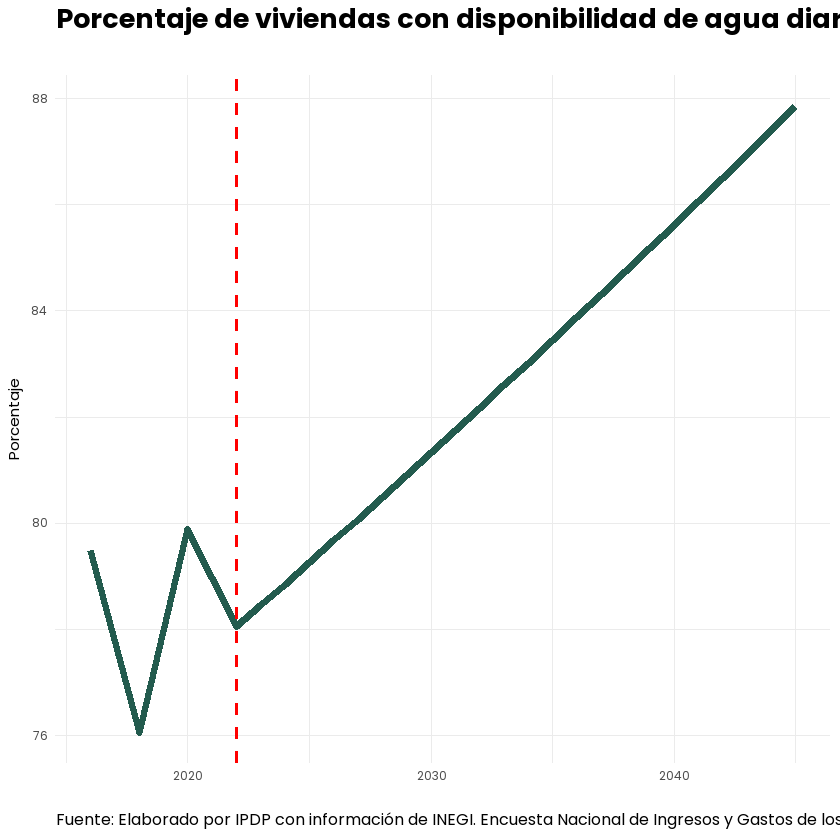

In [14]:
tabla_dotac_agua%>%
select(year,porcentaje)%>%
mutate(year=as.numeric(year))%>%
#Pegar hacia abajo
bind_rows(est_dotac)%>%
ggplot(aes(x=year,y=porcentaje))+
geom_line(color="#235B4E",size=2)+
  geom_vline(xintercept = 2022, linetype = "dashed", color = "red", size = 1)+
labs(title="Porcentaje de viviendas con disponibilidad de agua diaria",
     subtitle="",
     caption=paste0("Fuente: Elaborado por IPDP con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)."),
        x="",
        y="Porcentaje")+
theme_minimal()+
theme(legend.position="none",
      text=element_text(family="pop"),
      plot.title = element_text(size=20,face="bold"),
      plot.subtitle = element_text(size=15,face="italic"),
      plot.caption = element_text(size=12,hjust=0))

ggsave("dotacion_agua.png",width=12,height=10,dpi=100, bg="white")


In [15]:
serie_completa <- bind_rows(
  tabla_dotac_agua %>%
    mutate(year = as.numeric(year)) %>%
    intervals("porcentaje", margen = 0, año_base = 2022),
  
  est_dotac %>%
    mutate(year = as.numeric(year)) %>%
    intervals("porcentaje", margen = 0.0005 , año_base = 2022)
)
serie_completa

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2016,79.49000,79.49000,79.49000
2018,76.07000,76.07000,76.07000
2020,79.88000,79.88000,79.88000
2022,78.05000,78.05000,78.05000
2023,78.45214,78.49137,78.41294
2024,78.85636,78.93523,78.77756
2025,79.26265,79.38161,79.14388
2026,79.67104,79.83050,79.51190
2027,80.08154,80.28194,79.88163


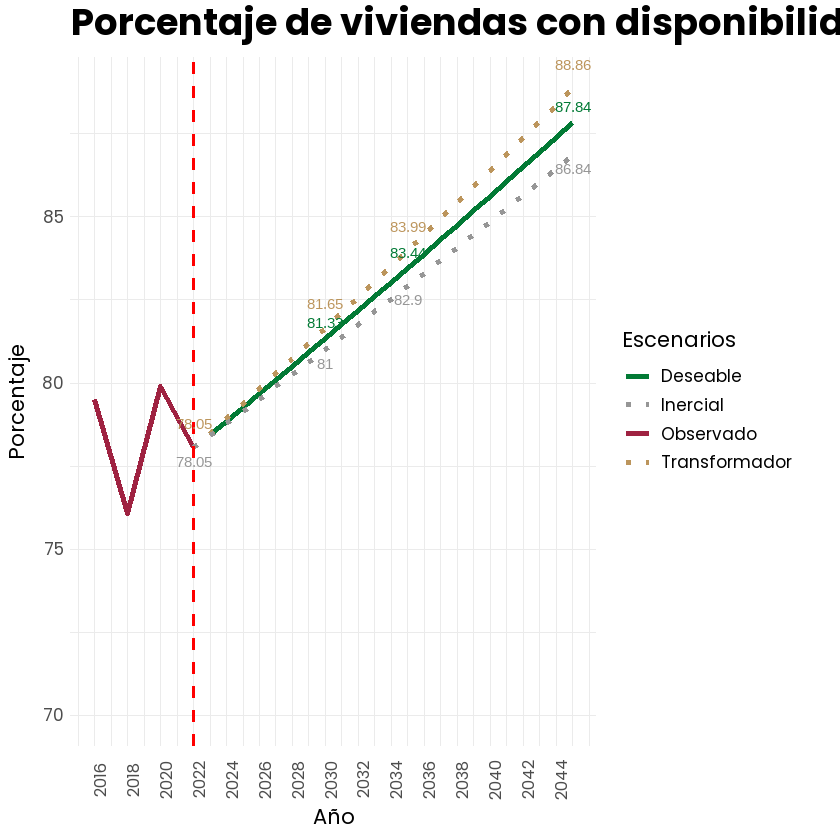

In [16]:
grafica_bonita(
  data = serie_completa,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de viviendas con disponibilidad de agua diaria",
  linea_vertical = 2022,
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Transformador",
  nombre_intervalo_inferior = "Inercial",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 70
)

ggsave("agua_diaria_estimada.png", width = 12, height = 10, dpi = 100, bg = "white")

In [17]:
est_disp<-estimacion(tabla_disp_agua,2020,2022,5,"porcentaje")
est_disp

year,porcentaje
<int>,<dbl>
2023,92.56942
2024,92.77931
2025,92.98968
2026,93.20052
2027,93.41184
2028,93.62365
2029,93.83593
2030,94.04869
2031,94.26194


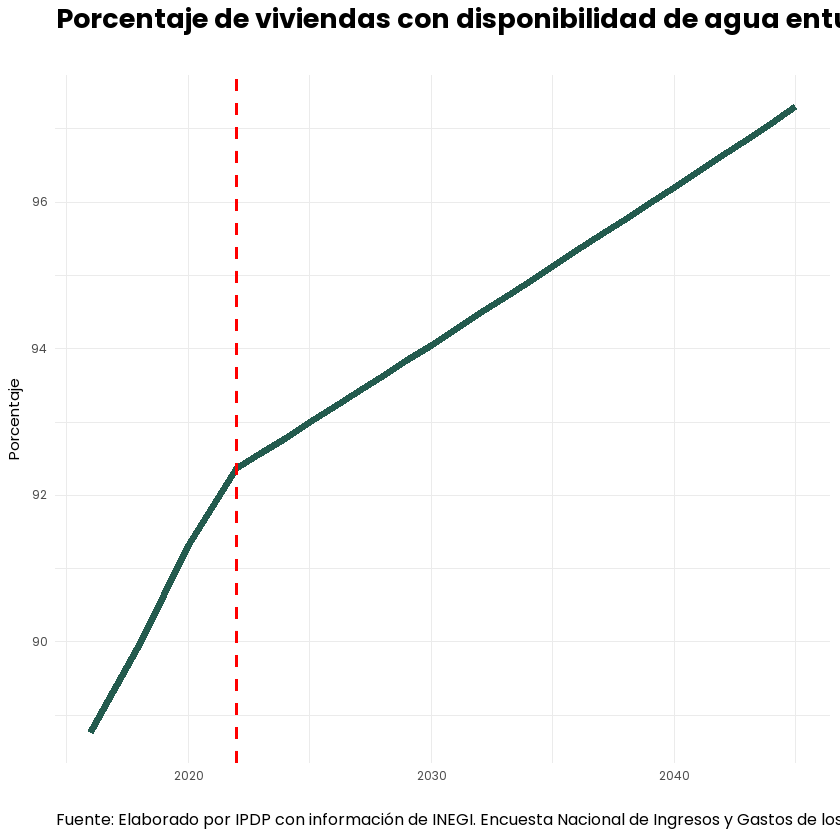

In [18]:
tabla_disp_agua%>%
select(year,porcentaje)%>%
mutate(year=as.numeric(year))%>%
#Pegar hacia abajo
bind_rows(est_disp)%>%
ggplot(aes(x=year,y=porcentaje))+
geom_line(color="#235B4E",size=2)+
  geom_vline(xintercept = 2022, linetype = "dashed", color = "red", size = 1)+
labs(title="Porcentaje de viviendas con disponibilidad de agua entubada dentro de la vivienda",
     subtitle="",
     caption=paste0("Fuente: Elaborado por IPDP con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)."),
        x="",
        y="Porcentaje")+
theme_minimal()+
theme(legend.position="none",
      text=element_text(family="pop"),
      plot.title = element_text(size=20,face="bold"),
      plot.subtitle = element_text(size=15,face="italic"),
      plot.caption = element_text(size=12,hjust=0))

ggsave("disp_agua.png",width=12,height=10,dpi=100, bg="white")


In [19]:
tabla_fugas_agua

p4_1_4,personas,personas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2178683,0.03960191,24.85,0.03621243,2017
1,2354994,0.02640651,33.93,0.02473607,2019
1,2250081,0.02684317,32.34,0.02598258,2021
1,2880457,0.02507924,38.02,0.02274877,2023


In [20]:
est_fugas<-estimacion(tabla_fugas_agua,2017,2023,20,"porcentaje")
est_fugas

year,porcentaje
<int>,<dbl>
2024,38.83706
2025,39.67169
2026,40.52425
2027,41.39513
2028,42.28473
2029,43.19344
2030,44.12169
2031,45.06988
2032,46.03845


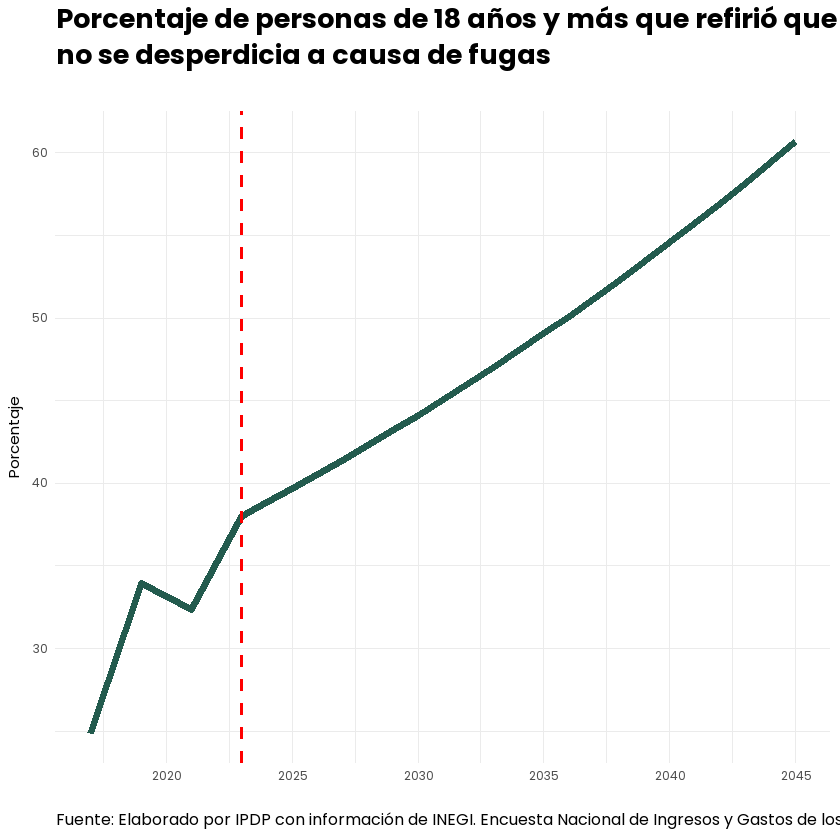

In [21]:
tabla_fugas_agua%>%
select(year,porcentaje)%>%
mutate(year=as.numeric(year))%>%
#Pegar hacia abajo
bind_rows(est_fugas)%>%
ggplot(aes(x=year,y=porcentaje))+
geom_line(color="#235B4E",size=2)+
  geom_vline(xintercept = 2023, linetype = "dashed", color = "red", size = 1)+
labs(title="Porcentaje de personas de 18 años y más que refirió que el agua potable en la ciudad
no se desperdicia a causa de fugas",
     subtitle="",
     caption=paste0("Fuente: Elaborado por IPDP con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)."),
        x="",
        y="Porcentaje")+
theme_minimal()+
theme(legend.position="none",
      text=element_text(family="pop"),
      plot.title = element_text(size=20,face="bold"),
      plot.subtitle = element_text(size=15,face="italic"),
      plot.caption = element_text(size=12,hjust=0))

ggsave("fugas.png",width=12,height=10,dpi=100, bg="white")

In [22]:
serie_completa <- bind_rows(
  tabla_disp_agua %>%
    mutate(year = as.numeric(year)) %>%
    intervals("porcentaje", margen = 0, año_base = 2022),
  
  est_disp %>%
    mutate(year = as.numeric(year)) %>%
    intervals("porcentaje", margen = 0.0005 , año_base = 2022)
)
serie_completa

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2016,88.77000,88.77000,88.77000
2018,89.97000,89.97000,89.97000
2020,91.32000,91.32000,91.32000
2022,92.36000,92.36000,92.36000
2023,92.56942,92.61570,92.52316
2024,92.77931,92.87211,92.68660
2025,92.98968,93.12923,92.85033
2026,93.20052,93.38706,93.01435
2027,93.41184,93.64561,93.17866


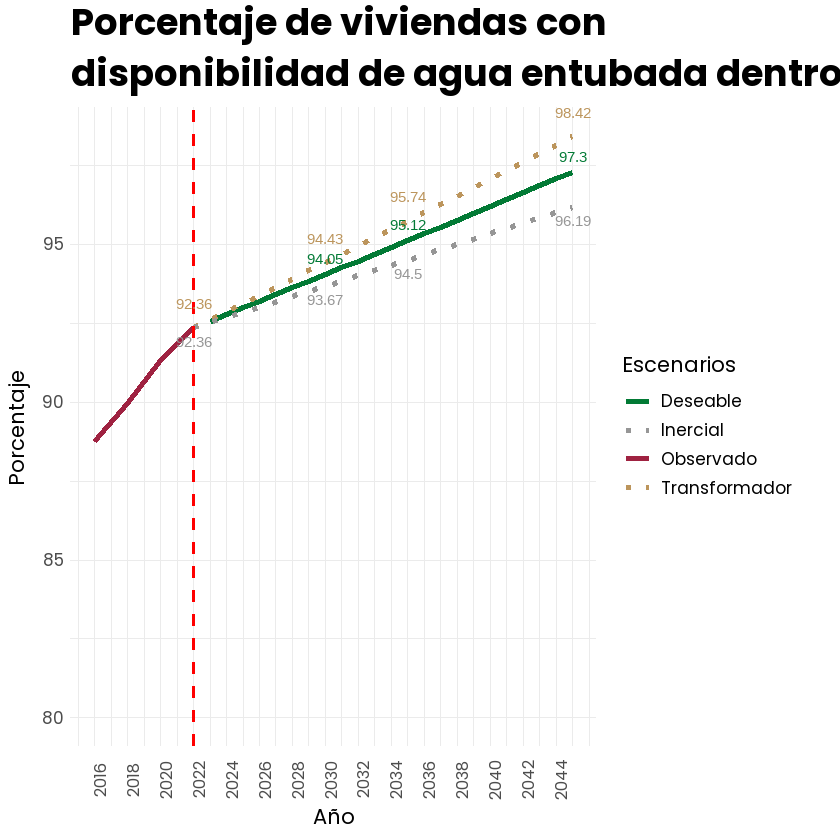

In [23]:
grafica_bonita(
  data = serie_completa,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de viviendas con 
disponibilidad de agua entubada dentro de la vivienda",
  linea_vertical = 2022,
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Transformador",
  nombre_intervalo_inferior = "Inercial",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 80
)

ggsave("disp_agua_estimada.png", width = 12, height = 10, dpi = 100, bg = "white")

In [24]:
serie_completa <- bind_rows(
  tabla_fugas_agua %>%
    mutate(year = as.numeric(year)) %>%
    intervals("porcentaje", margen = 0, año_base = 2021),
  
  est_fugas %>%
    mutate(year = as.numeric(year)) %>%
    intervals("porcentaje", margen = 0.005 , año_base = 2021)
)
serie_completa

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2017,24.85000,24.85000,24.85000
2019,33.93000,33.93000,33.93000
2021,32.34000,32.34000,32.34000
2023,38.02000,38.02000,38.02000
2024,38.83706,39.42254,38.26029
2025,39.67169,40.47109,38.88807
2026,40.52425,41.54754,39.52616
2027,41.39513,42.65261,40.17472
2028,42.28473,43.78708,40.83392


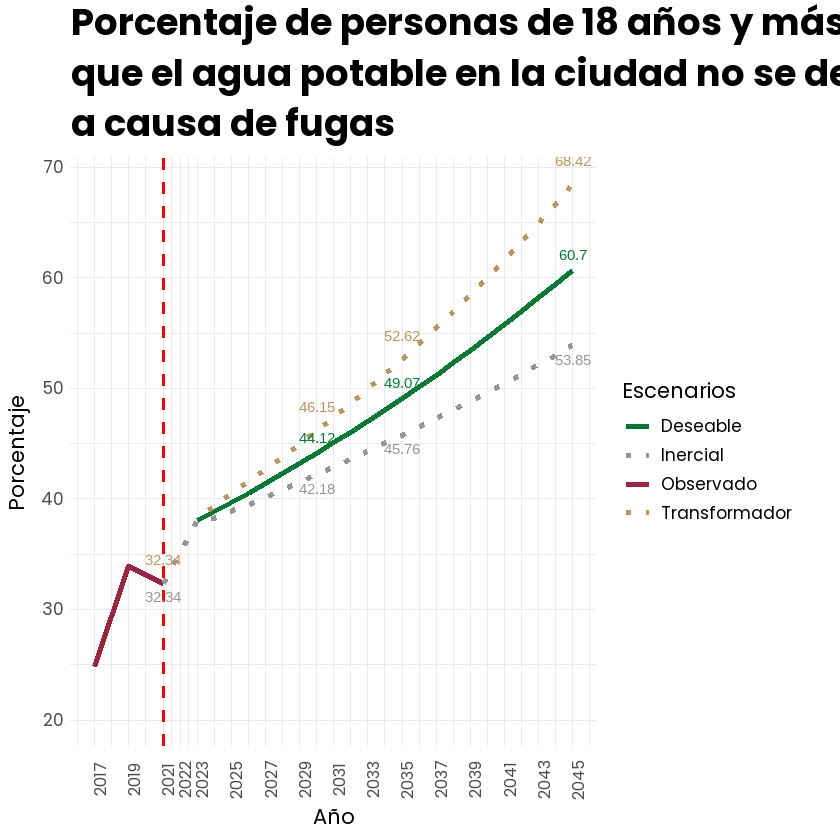

In [25]:
grafica_bonita(
  data = serie_completa,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de personas de 18 años y más que refirió 
que el agua potable en la ciudad no se desperdicia 
a causa de fugas",
  linea_vertical = 2021,
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Transformador",
  nombre_intervalo_inferior = "Inercial",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 20
)

ggsave("fugas_estimada.png", width = 12, height = 10, dpi = 100, bg = "white")

In [63]:
tabla_fugas_agua%>%
select(year,porcentaje)%>%
mutate(year=as.numeric(year))%>%
#Pegar hacia abajo
bind_rows(est_fugas)

year,porcentaje
<dbl>,<dbl>
2017,24.85000
2019,33.93000
2021,32.34000
2023,38.02000
2024,38.83706
2025,39.67169
2026,40.52425
2027,41.39513
2028,42.28473


In [110]:
generar_grafica <- function(tabla_obs, tabla_est, margen, titulo,
                            nombre_archivo, nombre_estimado_futuro,
                            nombre_intervalo_superior, nombre_intervalo_inferior,
                            limite_inferior_y, variable_intervals = "porcentaje") {

  serie_completa <- dplyr::bind_rows(
    tabla_obs %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(variable_intervals, margen = 0, año_base = 2022),

    tabla_est %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(variable_intervals, margen = margen, año_base = 2022)
  )

  grafica <- grafica_bonita(
    data = serie_completa,
    x = "year",
    y = "estimado",
    titulo = titulo,
    linea_vertical = 2022,
    mostrar_intervalo = "ambos",
    nombre_observado = "Observado",
    nombre_estimado_futuro = nombre_estimado_futuro,
    nombre_intervalo_superior = nombre_intervalo_superior,
    nombre_intervalo_inferior = nombre_intervalo_inferior,
    mostrar_leyenda = TRUE,
    fuente = "pop",
    etiqueta_x = "Año",
    etiqueta_y = "Porcentaje",
    titulo_leyenda = "Escenarios",
    limite_inferior_y = limite_inferior_y
  )

  ggplot2::ggsave(nombre_archivo, grafica, width = 12, height = 10, dpi = 100, bg = "white")
}


In [119]:
configuraciones <- tibble::tibble(
  tabla_obs = list(tabla_fugas_agua, tabla_disp_agua, tabla_dotac_agua),
  tabla_est = list(est_fugas, est_disp, est_dotac),
  margen = c(0.002, 0.001, 0.0005),
  nombre_archivo = c("fugas_estimada.png",
                     "disp_agua_estimada.png",
                     "agua_diaria_estimada.png"),
  titulo = c("Porcentaje de viviendas con fugas de agua",
             "Porcentaje de viviendas con disponibilidad de agua",
             "Porcentaje de viviendas con disponibilidad de agua diaria"),
  nombre_estimado_futuro = c("Transformador", "Sostenible", "Deseable"),
  nombre_intervalo_superior = c("Escenario alto", "Máximo", "Transformador"),
  nombre_intervalo_inferior = c("Inercial", "Mínimo", "Inercial"),
  limite_inferior_y = c(20,80,70),
  variable_intervals = c("porcentaje", "porcentaje", "porcentaje")
)


In [120]:
pmap(
  configuraciones,
  function(tabla_obs, tabla_est, margen, nombre_archivo,
           titulo, nombre_estimado_futuro,
           nombre_intervalo_superior, nombre_intervalo_inferior,
           limite_inferior_y, variable_intervals) {
    generar_grafica(
      tabla_obs = tabla_obs,
      tabla_est = tabla_est,
      margen = margen,
      titulo = titulo,
      nombre_archivo = nombre_archivo,
      nombre_estimado_futuro = nombre_estimado_futuro,
      nombre_intervalo_superior = nombre_intervalo_superior,
      nombre_intervalo_inferior = nombre_intervalo_inferior,
      limite_inferior_y = limite_inferior_y,
      variable_intervals = variable_intervals
    )
  }
)


[[1]]
[1] "fugas_estimada.png"

[[2]]
[1] "disp_agua_estimada.png"

[[3]]
[1] "agua_diaria_estimada.png"